# Importations

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model,Model,Sequential

In [2]:
import tensorflow as tf

In [7]:
tf.test.is_built_with_cuda()

True

In [8]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [9]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [11]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.activations import relu

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,RocCurveDisplay,roc_curve

In [13]:
from aizynthfinder.chem import *
from aizynthfinder.utils import *
from aizynthfinder.training import *
from aizynthfinder.context import *
import numpy as np


In [1]:
from aizynthfinder.utils.models import LocalKerasModel

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from keras.utils.vis_utils import plot_model

In [17]:
import SelectionGroup

In [18]:
from tqdm.notebook import tqdm

In [19]:
from tensorflow.keras.optimizers import Adam

# Modeles

### Récupération du modèle d'aizynth et création d'un nouveau

In [4]:
model = LocalKerasModel("C:/Users/Yassine/Desktop/aizynth/uspto_filter_model.hdf5")

In [5]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                              

In [21]:
model.model.trainable = False

In [22]:
model_wo_output1 = Model(inputs = model.model.layers[0].input, outputs = model.model.layers[3].output)
model_wo_output1.compile()
model_wo_output1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
Total params: 2,098,176
Trainable params: 0
Non-trainable params: 2,098,176
_________________________________________________________________


In [23]:
model_wo_output2 = Model(inputs = model.model.layers[2].input, outputs = model.model.layers[4].output)
model_wo_output2.compile()
model_wo_output2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
Total params: 2,098,176
Trainable params: 0
Non-trainable params: 2,098,176
_________________________________________________________________


In [24]:
layer_in = Input(shape = (2048,))
hidden = Dense(1024,name = "dense_1")(layer_in)
layer_out = Dense(1,name = "dense_2")(hidden)
#model_tl = Model(layer_in,layer_out)

In [25]:
concat = tf.keras.layers.Concatenate()([model.model.layers[3].output,model.model.layers[4].output])

In [77]:
hidden1 = tf.keras.layers.Dense(1024,name = "Dense_3",activation = 'relu')(concat)
#hidden2 = tf.keras.layers.Dense(1024, name = "Dense_4")(hidden1)
layer_out = tf.keras.layers.Dense(1,name = "dense_5",)(hidden1)

KeyboardInterrupt: 

In [66]:
new_model = Model(inputs = [model.model.layers[0].input,model.model.layers[2].input],outputs = layer_out)

In [67]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 1024)         2098176     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_12 (Dropout)           (None, 1024)         0           ['dense_11[0][0]']               
                                                                                            

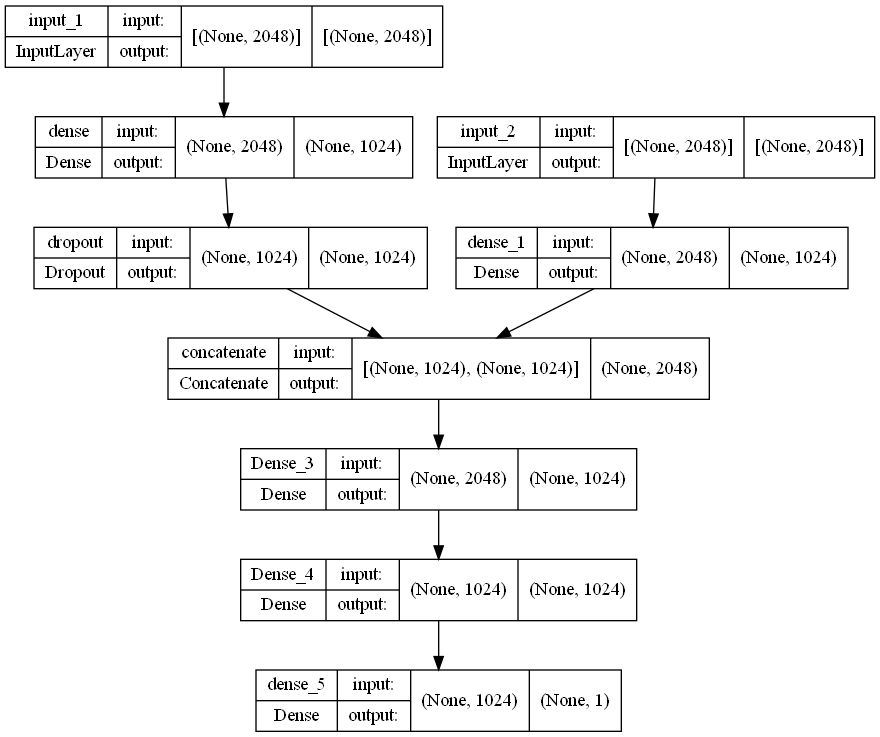

In [29]:
plot_model(new_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
new_model.layers[1]._name = "dense_11"
new_model.layers[3]._name = "dropout_12"
new_model.layers[4]._name = "dense_21"

In [31]:

new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 1024)         2098176     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_12 (Dropout)           (None, 1024)         0           ['dense_11[0][0]']               
                                                                                            

# Récupération des Datas 

In [32]:
def fp_from_fp_db(fp_db):
    res = np.zeros(2048)
    list_idx = fp_db.split(" ")
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

In [33]:
def input_model_from_db(base_fp):
    prod_fp_db,rxn_fp_db = base_fp["Product_Fingerprint"],base_fp["Reaction_Fingerprint"]
    prod_fp,rxn_fp = np.empty(base_fp.shape[0],dtype = 'object'),np.empty(base_fp.shape[0],dtype = 'object')
    for i in range(base_fp.shape[0]):
        prod_fp[i]=fp_from_fp_db(prod_fp_db.iloc[i])
        rxn_fp[i]=fp_from_fp_db(rxn_fp_db.iloc[i])
    return prod_fp,rxn_fp

In [34]:
def get_fp_db_from_idx(base_idx,base_fp):
    return base_fp.iloc[base_idx["Indices"].values]

In [35]:
fname_fp_false = "C:/Users/Clément/Desktop/PSC/PSC_final/Data/False_reactions/Reactions_Fingerprint_False.csv"
fname_fp_true = "C:/Users/Clément/Desktop/PSC/PSC_final/Data/True_reactions/Reactions_Fingerprint_True.csv"
fname_groups_false = "C:/Users/Clément/Desktop/PSC/PSC_final/Data/False_reactions/False_reac_groups.csv"
fname_groups_true = "C:/Users/Clément/Desktop/PSC/PSC_final/Data/True_reactions/True_reac_groups.csv"

In [36]:
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)
data_groups_false = pd.read_csv(fname_groups_false)
data_groups_true = pd.read_csv(fname_groups_true)

In [37]:
data_fp_true.head()

,Unnamed: 0,Product_Fingerprint,Reaction_Fingerprint
0,0,13 80 91 251 275 294 350 495 556 650 695 728 9...,13 80--2 91 124--1 222--1 275 294--1 473--1 55...
1,1,13 80 91 251 350 495 650 692 695 728 1057 1147...,13 80--1 91 124--1 222--1 294--1 473--1 807--1...
2,2,1 13 80 91 203 283 350 420 556 650 695 1057 11...,13 80--2 91 124--1 222--1 294--1 473--1 556 68...
3,3,13 80 91 251 275 294 350 495 556 650 695 728 9...,13 80--2 91 124--1 222--1 275 294--1 473--1 55...
4,4,13 80 91 251 350 495 650 692 695 728 1057 1147...,13 80--1 91 124--1 222--1 294--1 473--1 807--1...


In [38]:
data_groups_false.head()

,Unnamed: 0,Groupes
0,0,#061#069#201
1,1,#003#005#026#075#076
2,2,#019#037#039#075#076#201#202
3,3,#003#005#075#076#199
4,4,#009#047#048#050#061#069#075#078#080#083#084#2...


In [39]:
data_groups_true.head()

,Unnamed: 0,Groupes
0,0,#061#065#161#163
1,1,#061#065#161#163
2,2,#061#064#161#163
3,3,#061#065#161#163
4,4,#061#065#161#163


In [40]:
data_groups_true.iloc[[1,3,4,5,8]]

,Unnamed: 0,Groupes
1,1,#061#065#161#163
3,3,#061#065#161#163
4,4,#061#065#161#163
5,5,#061#064#161#163
8,8,#150#201#202


In [41]:
data_fp_true[["Product_Fingerprint","Reaction_Fingerprint"]]

,Product_Fingerprint,Reaction_Fingerprint
0,13 80 91 251 275 294 350 495 556 650 695 728 9...,13 80--2 91 124--1 222--1 275 294--1 473--1 55...
1,13 80 91 251 350 495 650 692 695 728 1057 1147...,13 80--1 91 124--1 222--1 294--1 473--1 807--1...
2,1 13 80 91 203 283 350 420 556 650 695 1057 11...,13 80--2 91 124--1 222--1 294--1 473--1 556 68...
3,13 80 91 251 275 294 350 495 556 650 695 728 9...,13 80--2 91 124--1 222--1 275 294--1 473--1 55...
4,13 80 91 251 350 495 650 692 695 728 1057 1147...,13 80--1 91 124--1 222--1 294--1 473--1 807--1...
...,...,...
1808249,71 119 131 162 222 277 352 389 675 714 736 776...,45--1 172--1 230--1 271--1 604--1 644--1 650--...
1808250,33 45 58 71 131 162 222 233 239 277 352 389 60...,33 58 114--2 119--1 233 239 389--2 392--2 609 ...
1808251,33 45 49 58 71 131 162 233 239 352 389 461 609...,33 58 114--2 119--1 233 239 389--1 392--2 609 ...
1808252,33 45 49 71 131 162 238 239 352 389 461 609 62...,33 114--2 119--1 238 239 389--1 392--2 485--1 ...


In [42]:
fp_alcool = SelectionGroup.select_grp(data_fp_false,data_fp_true,["Alcool"])

  0%|          | 0/46648 [00:00<?, ?it/s]

  0%|          | 0/223211 [00:00<?, ?it/s]

In [43]:
fp_alcool

[(array([[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]]),
  array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0., -1., -1., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]]),
  array([[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0., -2.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]

In [44]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 1024)         2098176     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_12 (Dropout)           (None, 1024)         0           ['dense_11[0][0]']               
                                                                                            

In [45]:
a,b,c,d = fp_alcool[0]

In [46]:
a.shape

(46648, 2048)

In [47]:
b.shape

(46648, 2048)

In [1]:
c.shape

NameError: name 'c' is not defined

In [48]:
c = c[:b.shape[0]]

In [49]:
d = d[:b.shape[0]]

In [50]:
y = [1]*b.shape[0] + [0]*b.shape[0]

In [51]:
y = np.array(y)

In [52]:
x_prod,x_rxn = np.concatenate((a,c)),np.concatenate((b,d))

In [53]:
x_prod.shape

(93296, 2048)

## SETTING UP CALLBACKS

In [54]:
#We set up a reducing learning rate call back
reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=0.000001,
        cooldown=0,
        min_lr=0,
    )

In [55]:
#We set up an early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=20,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)


## Compiling Model And Fitting Data

In [68]:
new_model.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
                 loss = "binary_crossentropy",
                 metrics = ['Accuracy'])

In [69]:
new_model.fit(x = [x_prod,x_rxn],y = y,epochs = 100,verbose = 1,validation_split = 0.1, callbacks = [reduce_lr, early_stop])

Epoch 1/100
2624/2624 [==============================] - 13s 5ms/step - loss: 4.4630 - Accuracy: 0.7061 - val_loss: 9.5774 - val_Accuracy: 0.3700 - lr: 0.0010
Epoch 2/100
2624/2624 [==============================] - 10s 4ms/step - loss: 4.1789 - Accuracy: 0.7257 - val_loss: 8.8057 - val_Accuracy: 0.4218 - lr: 0.0010
Epoch 3/100
2624/2624 [==============================] - 10s 4ms/step - loss: 4.0054 - Accuracy: 0.7374 - val_loss: 8.1038 - val_Accuracy: 0.4676 - lr: 0.0010
Epoch 4/100
2624/2624 [==============================] - 10s 4ms/step - loss: 3.5698 - Accuracy: 0.7665 - val_loss: 5.2846 - val_Accuracy: 0.6534 - lr: 0.0010
Epoch 5/100
2624/2624 [==============================] - 10s 4ms/step - loss: 3.4945 - Accuracy: 0.7713 - val_loss: 5.0885 - val_Accuracy: 0.6660 - lr: 0.0010
Epoch 6/100
2624/2624 [==============================] - 11s 4ms/step - loss: 3.4845 - Accuracy: 0.7721 - val_loss: 5.0351 - val_Accuracy: 0.6696 - lr: 0.0010
Epoch 7/100
2624/2624 [=======================

## Scoring

In [70]:
y_pred = new_model.predict([x_prod, x_rxn])

In [71]:
y_pred_bin = [x>0.5 for x in y_pred]

In [72]:
precision, recall, fscore, support = score(y, y_pred_bin, pos_label=1, average='binary')

[93296, 93296]
[93296, 93296]
[93296, 93296]


In [73]:
precision, recall, fscore, support

(0.8828035377271214, 0.5114045618247299, 0.6476361119029198, None)

In [74]:
def plot_roc_curve(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plot_roc_curve_from_res(fpr,tpr,thresholds)


In [75]:
def plot_roc_curve_from_res(fpr,tpr,thresholds):
    plt.plot(fpr,tpr)
    plt.xlabel("taux de faux positifs")
    plt.ylabel("taux de vrais positifs")
    plt.show()

[93296, 93296]


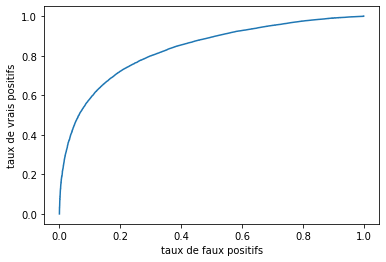

In [76]:
plot_roc_curve(y,y_pred)

In [2]:
def fp_np_arr_out_of_database(database, column_index):
    progress_bar = tq.tqdm(total=database.shape[0])
    res_l = []
    for i in range(database.shape[0]):
        try :
            res_l.append(fp_out_of_database_line(database.iloc[i,column_index]))
        except AttributeError :
            continue
        progress_bar.update(1)
    return np.array(res_l)